In [1]:
import intake
#from easygems import healpix as egh
import matplotlib.pyplot as plt
import warnings
import xarray as xr
from pathlib import Path
#import healpy as hp
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

# Loading Imerg area_mean and area_frac

In [2]:
imerg_path_metrics = f"/g/data/nf33/cb4968/metrics/observations/IMERG/doc_metrics/" 
imerg_file_area_frac = "area_fraction/IMERG/area_fraction_IMERG_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"
imerg_file_mean_area = "mean_area/IMERG/mean_area_IMERG_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"

In [3]:
# Area fraction and mean area
imerg_area_frac = xr.open_dataset(f"{imerg_path_metrics}/{imerg_file_area_frac}")
imerg_mean_area = xr.open_dataset(f"{imerg_path_metrics}/{imerg_file_mean_area}")

# Select percentile
per = 95
imerg_area_frac = imerg_area_frac[f"area_fraction_thres_pr_percentiles_{per}"]
imerg_mean_area = imerg_mean_area[f"mean_area_thres_pr_percentiles_{per}"]


# loading r_700_mean_100_149_-10_10.nc 

In [4]:
# resampling it to 3-hourly

era5_r_700 = xr.open_dataset('/scratch/nf33/gs5098/data/r_700_mean_100_149_-13_13_2020_03_2021_02.nc')
era5_r_700_3h = era5_r_700.resample(time='3H').mean()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


In [5]:
# Subset r_700_3h to the times in area_frac (two timesteps were missing in area_frac data)
era5_r_700_3h = era5_r_700_3h.sel(time=imerg_area_frac.time)
era5_r_700_3h

<xarray.Dataset> Size: 35kB
Dimensions:  (time: 2918)
Coordinates:
    level    int32 4B 700
  * time     (time) datetime64[ns] 23kB 2020-03-01 ... 2021-02-28T21:00:00
Data variables:
    r        (time) float32 12kB 63.87 63.19 62.68 63.01 ... 61.98 62.29 62.41

In [6]:
# Mean
imerg_area_frac_mean = imerg_area_frac.mean()
imerg_mean_area_mean = imerg_mean_area.mean()
era5_r_700_3h_mean = era5_r_700_3h.r.mean()

In [7]:
print(era5_r_700_3h_mean)

<xarray.DataArray 'r' ()> Size: 4B
array(65.88277, dtype=float32)
Coordinates:
    level    int32 4B 700


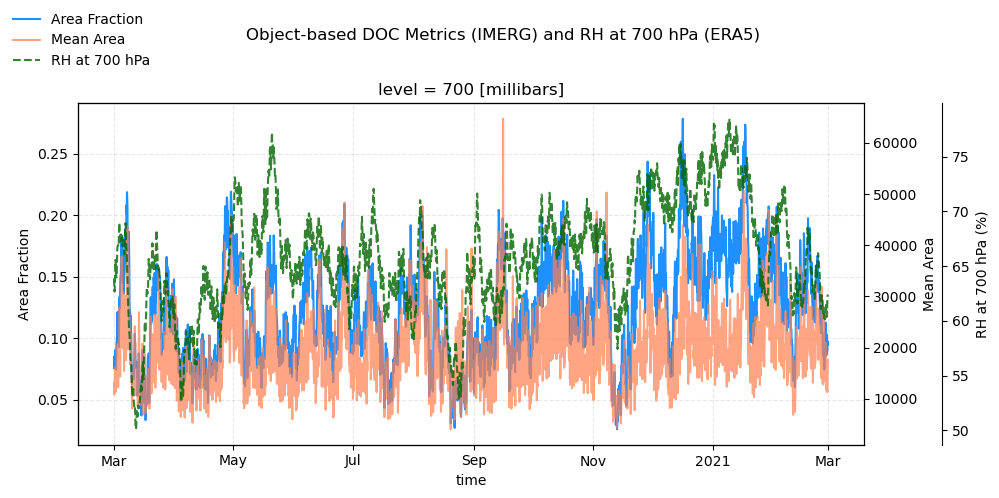

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Left y-axis: area_frac
line1, = imerg_area_frac.plot(ax=ax, color="dodgerblue", label="Area Fraction")
ax.set_ylabel("Area Fraction")

# First right y-axis: mean_area
ax2 = ax.twinx()
line2, = imerg_mean_area.plot(ax=ax2, color="coral", alpha=0.7, label="Mean Area")
ax2.set_ylabel("Mean Area")

# Second right y-axis: r_700_3h.r
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.spines['right'].set_visible(True)
line3, = era5_r_700_3h.r.plot(ax=ax3, color="darkgreen", linestyle="--", alpha=0.8, label="RH at 700 hPa")
ax3.set_ylabel("RH at 700 hPa (%)")


lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper left", frameon=False)


fig.suptitle("Object-based DOC Metrics (IMERG) and RH at 700 hPa (ERA5)", y=0.95)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [9]:
#Daily
imerg_area_frac_daily = imerg_area_frac.resample({"time":"D"}).mean()
imerg_mean_area_daily = imerg_mean_area.resample({"time":"D"}).mean()
era5_rh_700_daily    = era5_r_700_3h.r.resample({"time":"D"}).mean()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


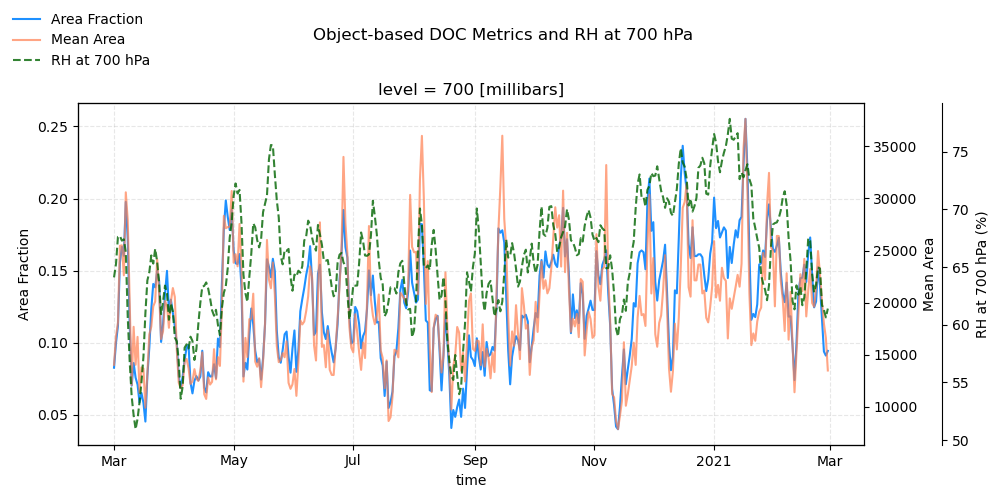

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Left y-axis: area_frac
line1, = imerg_area_frac_daily.plot(ax=ax, color="dodgerblue", label="Area Fraction")
ax.set_ylabel("Area Fraction")

# First right y-axis: mean_area
ax2 = ax.twinx()
line2, = imerg_mean_area_daily.plot(ax=ax2, color="coral", alpha=0.7, label="Mean Area")
ax2.set_ylabel("Mean Area")

# Second right y-axis: r_700_3h.r
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.spines['right'].set_visible(True)
line3, = era5_rh_700_daily.plot(ax=ax3, color="darkgreen", linestyle="--", alpha=0.8, label="RH at 700 hPa")
ax3.set_ylabel("RH at 700 hPa (%)")


lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper left", frameon=False)


fig.suptitle("Object-based DOC Metrics and RH at 700 hPa", y=0.95)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [11]:
print('For IMERG:')
print(f"Temporal Mean of Area Fraction: {imerg_area_frac_daily.mean().item():.2f}")
print(f"Temporal Mean of Mean Area: {imerg_mean_area_daily.mean().item():.2f}")
print(f"Temporal Mean of RH at 700 hPa: {era5_rh_700_daily.mean().item():.2f}")


For IMERG:
Temporal Mean of Area Fraction: 0.12
Temporal Mean of Mean Area: 19078.71
Temporal Mean of RH at 700 hPa: 65.89


Text(0.0, 1.0, 'Object-based DOC metrics')

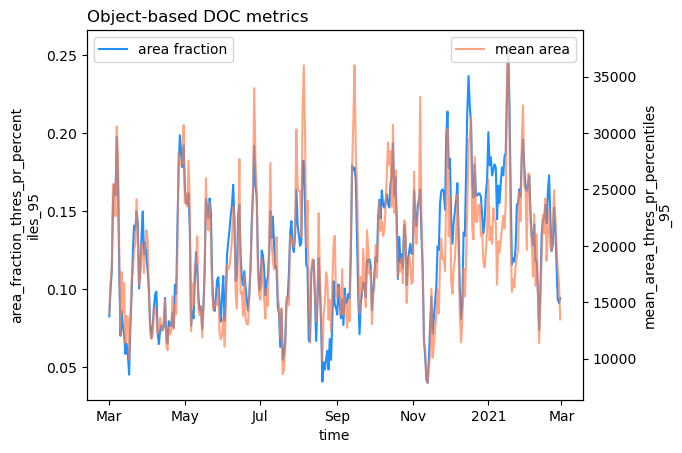

In [12]:
# Time series of metrics
fig, ax = plt.subplots()
imerg_area_frac_daily.plot(ax = ax, c = "dodgerblue", label = "area fraction")
ax.legend(loc = 2)
ax2 = ax.twinx()
imerg_mean_area_daily.plot(ax = ax2, c = "coral", alpha = 0.7, label = "mean area")
ax2.legend(loc = 1)
ax.set_title(f"Object-based DOC metrics", loc = "left")

In [13]:
ob_a = imerg_area_frac
ob_b = imerg_mean_area
ob_c = era5_r_700_3h.r

In [14]:
print('For IMERG:')
print(f"Temporal Mean of Area Fraction: {ob_a.mean().item():.2f}")
print(f"Temporal Mean of Mean Area: {ob_b.mean().item():.2f}")
print(f"Temporal Mean of RH at 700 hPa: {ob_c.mean().item():.2f}")


For IMERG:
Temporal Mean of Area Fraction: 0.12
Temporal Mean of Mean Area: 19075.57
Temporal Mean of RH at 700 hPa: 65.88


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

data = pd.DataFrame({
    'ob_area_frac': ob_a,
    'ob_mean_area': ob_b,
    'ob_r_700_3h.r': ob_c
})



print("Correlation matrix:")
print(data.corr())


Correlation matrix:
               ob_area_frac  ob_mean_area  ob_r_700_3h.r
ob_area_frac       1.000000      0.754921       0.626617
ob_mean_area       0.754921      1.000000       0.329832
ob_r_700_3h.r      0.626617      0.329832       1.000000


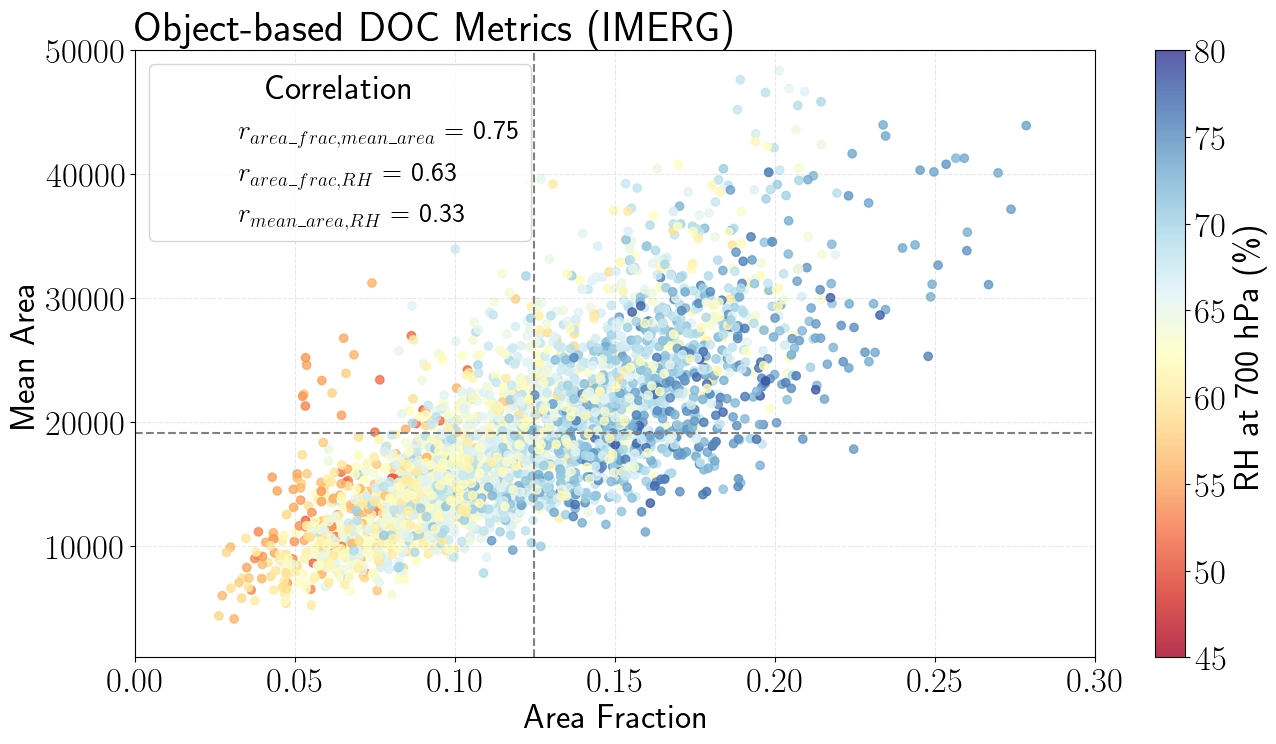

In [16]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import pandas as pd


data = pd.DataFrame({
    'area_frac': ob_a,
    'mean_area': ob_b,
    'r_700_3h.r': ob_c
})


corr_ab, _ = pearsonr(data['area_frac'], data['mean_area'])
corr_ac, _ = pearsonr(data['area_frac'], data['r_700_3h.r'])
corr_bc, _ = pearsonr(data['mean_area'], data['r_700_3h.r'])


plt.rcParams.update({"text.usetex": True, "font.size": 25})
fig, ax = plt.subplots(figsize=(14, 8))

sc = ax.scatter(data['area_frac'], data['mean_area'], c=data['r_700_3h.r'], cmap="RdYlBu", alpha=0.8, vmin= 45, vmax = 80)


ax.axhline(y=data['mean_area'].mean(), ls="--", c="grey")
ax.axvline(x=data['area_frac'].mean(), ls="--", c="grey")

ax.set_ylim(1000,50000)
ax.set_xlim(0,0.30)
ax.set_xlabel("Area Fraction")
ax.set_ylabel("Mean Area")
ax.set_title("Object-based DOC Metrics (IMERG)", loc="left")


cb = plt.colorbar(sc, ax=ax)
cb.set_label("RH at 700 hPa (\%)")


legend_elements = [
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,mean\_area}}$ = {corr_ab:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,RH}}$ = {corr_ac:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{mean\_area,RH}}$ = {corr_bc:.2f}")
]



ax.legend(handles=legend_elements, loc='upper left', frameon=True, title='Correlation', fontsize = 20)

# Grid and layout
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
ob_a

<xarray.DataArray 'area_fraction_thres_pr_percentiles_95' (time: 2918)> Size: 23kB
array([0.075854, 0.079805, 0.08574 , ..., 0.093766, 0.097986, 0.09491 ])
Coordinates:
  * time     (time) datetime64[ns] 23kB 2020-03-01 ... 2021-02-28T21:00:00

# UM Area mean, area fraction, and RelH at 700 hPa

In [17]:
# loading UM area_frac and area_mean

um_path_metrics = f"/g/data/nf33/cb4968/metrics/models/UM/doc_metrics/" 
um_file_area_frac = "area_fraction/n2560_RAL3p3/area_fraction_n2560_RAL3p3_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"
um_file_mean_area = "mean_area/n2560_RAL3p3/mean_area_n2560_RAL3p3_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"

In [18]:
# Area fraction and mean area
um_area_frac = xr.open_dataset(f"{um_path_metrics}/{um_file_area_frac}")
um_mean_area = xr.open_dataset(f"{um_path_metrics}/{um_file_mean_area}")

# Select percentile
per = 95
um_area_frac = um_area_frac[f"area_fraction_thres_pr_percentiles_{per}"]
um_mean_area = um_mean_area[f"mean_area_thres_pr_percentiles_{per}"]

In [19]:
print(um_mean_area.time)

<xarray.DataArray 'time' (time: 2920)> Size: 23kB
array(['2020-03-01T00:00:00.000000000', '2020-03-01T03:00:00.000000000',
       '2020-03-01T06:00:00.000000000', ..., '2021-02-28T15:00:00.000000000',
       '2021-02-28T18:00:00.000000000', '2021-02-28T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 23kB 2020-03-01 ... 2021-02-28T21:00:00


In [20]:
# loading UM RelH at 700hPa

um_metrics = pd.read_csv('/scratch/nf33/hk25_DOCmeso/UM_interp/UM_z5_700hPa_DomainAverage_MarCont.csv')
print(um_metrics.head())

                  time         ta        hur       hus
0  2020-01-20 00:00:00  283.60703  53.035973  0.005903
1  2020-01-20 03:00:00  283.57028  53.625706  0.005945
2  2020-01-20 06:00:00  283.75296  52.655994  0.005937
3  2020-01-20 09:00:00  283.94500  50.820965  0.005808
4  2020-01-20 12:00:00  283.90927  49.954700  0.005666


In [21]:

# Load the CSV and parse time
um_metrics = pd.read_csv('/scratch/nf33/hk25_DOCmeso/UM_interp/UM_z5_700hPa_DomainAverage_MarCont.csv', parse_dates=['time'])

# Drop any rows with NaN values
um_metrics = um_metrics.dropna()

# Set 'time' as the index
um_metrics = um_metrics.set_index('time')

# Convert to xarray Dataset
um_ds = um_metrics.to_xarray()

print(um_ds)


<xarray.Dataset> Size: 104kB
Dimensions:  (time: 3249)
Coordinates:
  * time     (time) datetime64[ns] 26kB 2020-01-20 ... 2021-03-01
Data variables:
    ta       (time) float64 26kB 283.6 283.6 283.8 283.9 ... 282.0 281.9 282.0
    hur      (time) float64 26kB 53.04 53.63 52.66 50.82 ... 64.47 64.18 63.27
    hus      (time) float64 26kB 0.005903 0.005945 ... 0.006455 0.006395


In [22]:
um_rh_700  = um_ds['hur']
print(um_rh_700)

<xarray.DataArray 'hur' (time: 3249)> Size: 26kB
array([53.035973, 53.625706, 52.655994, ..., 64.465965, 64.18493 ,
       63.2732  ])
Coordinates:
  * time     (time) datetime64[ns] 26kB 2020-01-20 ... 2021-03-01


In [23]:
# creating a subset with timesteps between 2020-04-01 and 2021-03-31

um_r_700_3h = um_rh_700.sel(time=slice("2020-03-01", "2021-02-28"))
print(um_r_700_3h)


<xarray.DataArray 'hur' (time: 2920)> Size: 23kB
array([65.27384 , 64.908844, 64.63999 , ..., 63.53478 , 64.465965,
       64.18493 ])
Coordinates:
  * time     (time) datetime64[ns] 23kB 2020-03-01 ... 2021-02-28T21:00:00


In [24]:
# Mean
um_area_frac_mean = um_area_frac.mean()
um_mean_area_mean = um_mean_area.mean()
um_r_700_3h_mean = um_r_700_3h.mean()

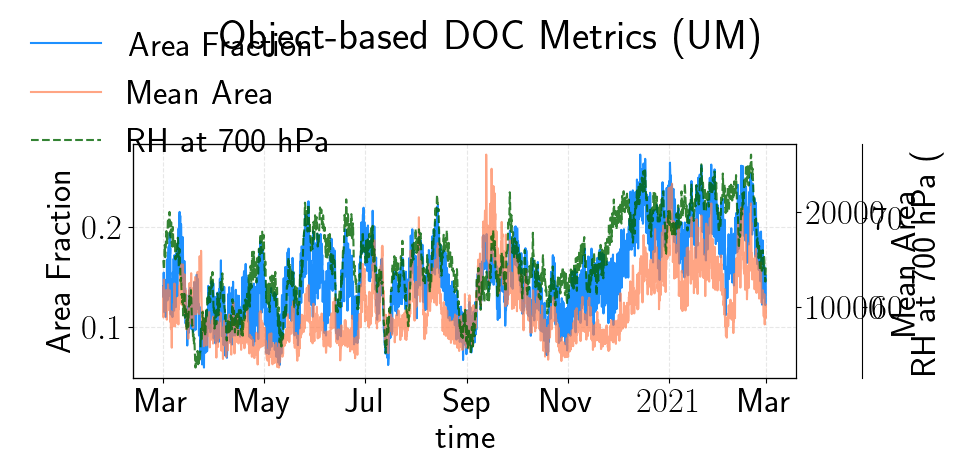

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Left y-axis: area_frac
line1, = um_area_frac.plot(ax=ax, color="dodgerblue", label="Area Fraction")
ax.set_ylabel("Area Fraction")

# First right y-axis: mean_area
ax2 = ax.twinx()
line2, = um_mean_area.plot(ax=ax2, color="coral", alpha=0.7, label="Mean Area")
ax2.set_ylabel("Mean Area")

# Second right y-axis: r_700_3h.r
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.spines['right'].set_visible(True)
line3, = um_r_700_3h.plot(ax=ax3, color="darkgreen", linestyle="--", alpha=0.8, label="RH at 700 hPa")
ax3.set_ylabel("RH at 700 hPa (%)")


lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper left", frameon=False)


fig.suptitle("Object-based DOC Metrics (UM)", y=0.95)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [26]:
print('For UM:')
print(f"Temporal Mean of Area Fraction: {um_area_frac.mean().item():.2f}")
print(f"Temporal Mean of Mean Area: {um_mean_area.mean().item():.2f}")
print(f"Temporal Mean of RH at 700 hPa: {um_rh_700.mean().item():.2f}")


For UM:
Temporal Mean of Area Fraction: 0.15
Temporal Mean of Mean Area: 10031.91
Temporal Mean of RH at 700 hPa: 64.92


In [27]:
um_a = um_area_frac
um_b = um_mean_area
um_c = um_r_700_3h

In [28]:
print('For UM:')
print(f"Temporal Mean of Area Fraction: {um_a.mean().item():.2f}")
print(f"Temporal Mean of Mean Area: {um_b.mean().item():.2f}")
print(f"Temporal Mean of RH at 700 hPa: {um_c.mean().item():.2f}")


For UM:
Temporal Mean of Area Fraction: 0.15
Temporal Mean of Mean Area: 10031.91
Temporal Mean of RH at 700 hPa: 65.33


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

data = pd.DataFrame({
    'um_area_frac': um_a,
    'um_mean_area': um_b,
    'um_r_700_3h': um_c
})



print("Correlation matrix (for UM):")
print(data.corr())

Correlation matrix (for UM):
              um_area_frac  um_mean_area  um_r_700_3h
um_area_frac      1.000000      0.724222     0.797040
um_mean_area      0.724222      1.000000     0.468331
um_r_700_3h       0.797040      0.468331     1.000000


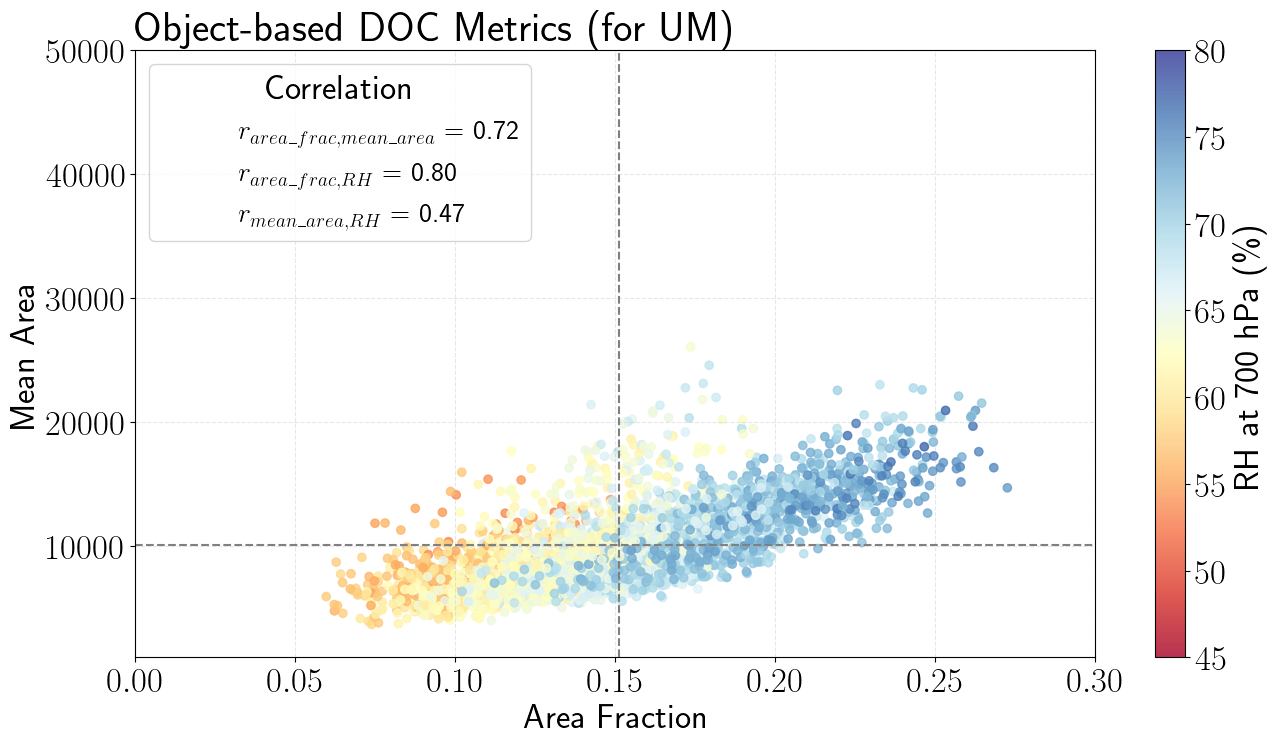

In [30]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import pandas as pd


data = pd.DataFrame({
    'um_area_frac': um_area_frac,
    'um_mean_area': um_mean_area,
    'um_r_700_3h': um_r_700_3h
})


corr_ab, _ = pearsonr(data['um_area_frac'], data['um_mean_area'])
corr_ac, _ = pearsonr(data['um_area_frac'], data['um_r_700_3h'])
corr_bc, _ = pearsonr(data['um_mean_area'], data['um_r_700_3h'])


plt.rcParams.update({"text.usetex": True, "font.size": 25})
fig, ax = plt.subplots(figsize=(14, 8))

sc = ax.scatter(data['um_area_frac'], data['um_mean_area'], c=data['um_r_700_3h'], cmap="RdYlBu", alpha=0.8, vmin = 45, vmax = 80)


ax.axhline(y=data['um_mean_area'].mean(), ls="--", c="grey")
ax.axvline(x=data['um_area_frac'].mean(), ls="--", c="grey")

ax.set_ylim(1000,50000)
ax.set_xlim(0,0.30)
ax.set_xlabel("Area Fraction")
ax.set_ylabel("Mean Area")
ax.set_title("Object-based DOC Metrics (for UM)", loc="left")


cb = plt.colorbar(sc, ax=ax)
cb.set_label("RH at 700 hPa (\%)")


legend_elements = [
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,mean\_area}}$ = {corr_ab:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,RH}}$ = {corr_ac:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{mean\_area,RH}}$ = {corr_bc:.2f}")
]



ax.legend(handles=legend_elements, loc='upper left', frameon=True, title='Correlation', fontsize = 20)

# Grid and layout
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


# ICON mean area, area fraction, and RH at 700 hPa

In [31]:
# loading UM area_frac and area_mean

icon_path_metrics = f"/g/data/nf33/cb4968/metrics/models/ICON/doc_metrics/" 
icon_file_area_frac = "area_fraction/icon_d3hp003/area_fraction_icon_d3hp003_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"
icon_file_mean_area = "mean_area/icon_d3hp003/mean_area_icon_d3hp003_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"

In [32]:
# Area fraction and mean area
icon_area_frac = xr.open_dataset(f"{icon_path_metrics}/{icon_file_area_frac}")
icon_mean_area = xr.open_dataset(f"{icon_path_metrics}/{icon_file_mean_area}")

# Select percentile
per = 95
icon_area_frac = icon_area_frac[f"area_fraction_thres_pr_percentiles_{per}"]
icon_mean_area = icon_mean_area[f"mean_area_thres_pr_percentiles_{per}"]

In [33]:
# loading UM RelH at 700hPa

icon_metrics = pd.read_csv('/scratch/nf33/hk25_DOCmeso/ICON_interp/ICON_z6_70000hPa_DomainAverage_MarCont.csv')
print(icon_metrics.head())

                  time         ta       hur       hus
0  2020-01-01 06:00:00  283.76068  66.52212  0.007491
1  2020-01-01 06:00:00  283.76068  66.52212  0.007491
2  2020-01-01 06:00:00  283.76068  66.52212  0.007491
3  2020-01-01 12:00:00  283.83264  65.15907  0.007341
4  2020-01-01 12:00:00  283.83264  65.15907  0.007341


In [34]:
# Load the CSV and parse time
icon_metrics = pd.read_csv('/scratch/nf33/hk25_DOCmeso/ICON_interp/ICON_z6_70000hPa_DomainAverage_MarCont.csv', parse_dates=['time'])

# Drop any rows with NaN values
icon_metrics = icon_metrics.dropna()

# Set 'time' as the index
icon_metrics = icon_metrics.set_index('time')

# Convert to xarray Dataset
icon_ds = icon_metrics.to_xarray()

print(icon_ds)

<xarray.Dataset> Size: 163kB
Dimensions:  (time: 5100)
Coordinates:
  * time     (time) datetime64[ns] 41kB 2020-01-01T06:00:00 ... 2021-03-01
Data variables:
    ta       (time) float64 41kB 283.8 283.8 283.8 283.8 ... 282.8 282.8 282.8
    hur      (time) float64 41kB 66.52 66.52 66.52 65.16 ... 65.78 65.78 65.78
    hus      (time) float64 41kB 0.007491 0.007491 ... 0.006989 0.006989


In [35]:
icon_rh_700  = icon_ds['hur']
print(icon_rh_700)

<xarray.DataArray 'hur' (time: 5100)> Size: 41kB
array([66.52212, 66.52212, 66.52212, ..., 65.776  , 65.776  , 65.776  ])
Coordinates:
  * time     (time) datetime64[ns] 41kB 2020-01-01T06:00:00 ... 2021-03-01


In [36]:
# creating a subset with timesteps between 2020-04-01 and 2021-03-31

icon_r_700_3h = icon_rh_700.sel(time=slice("2020-03-01", "2021-02-28"))
print(icon_r_700_3h)

<xarray.DataArray 'hur' (time: 4380)> Size: 35kB
array([49.57523, 49.57523, 49.57523, ..., 66.35723, 66.35723, 66.35723])
Coordinates:
  * time     (time) datetime64[ns] 35kB 2020-03-01 ... 2021-02-28T18:00:00


In [37]:
icon_r_700_3h.time

<xarray.DataArray 'time' (time: 4380)> Size: 35kB
array(['2020-03-01T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', ..., '2021-02-28T18:00:00.000000000',
       '2021-02-28T18:00:00.000000000', '2021-02-28T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 35kB 2020-03-01 ... 2021-02-28T18:00:00

In [38]:
# Mean
icon_area_frac_mean = icon_area_frac.mean()
icon_mean_area_mean = icon_mean_area.mean()
icon_r_700_3h_mean = icon_r_700_3h.mean()

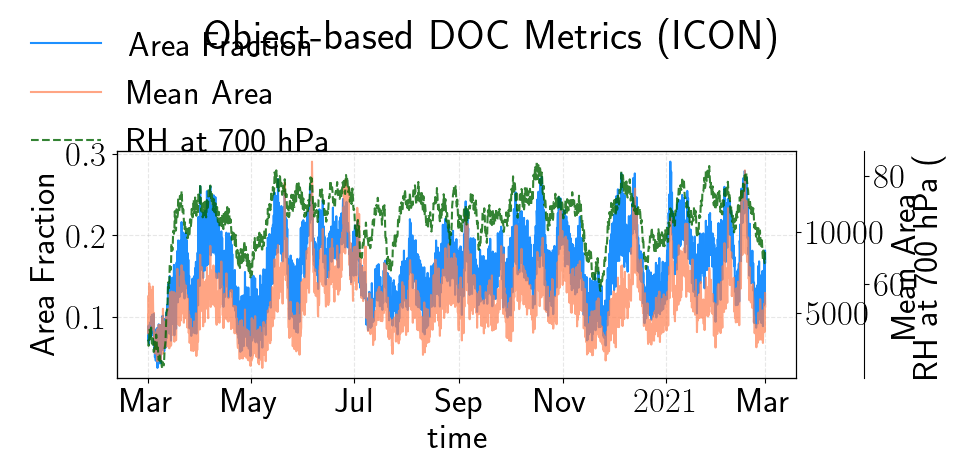

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Left y-axis: area_frac
line1, = icon_area_frac.plot(ax=ax, color="dodgerblue", label="Area Fraction")
ax.set_ylabel("Area Fraction")

# First right y-axis: mean_area
ax2 = ax.twinx()
line2, = icon_mean_area.plot(ax=ax2, color="coral", alpha=0.7, label="Mean Area")
ax2.set_ylabel("Mean Area")

# Second right y-axis: r_700_3h.r
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.spines['right'].set_visible(True)
line3, = icon_r_700_3h.plot(ax=ax3, color="darkgreen", linestyle="--", alpha=0.8, label="RH at 700 hPa")
ax3.set_ylabel("RH at 700 hPa (%)")


lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper left", frameon=False)


fig.suptitle("Object-based DOC Metrics (ICON)", y=0.95)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [40]:
icon_a = icon_area_frac
icon_b = icon_mean_area
icon_c = icon_r_700_3h

In [41]:
icon_c = icon_c.drop_duplicates(dim='time')

print(icon_c)

<xarray.DataArray 'hur' (time: 1460)> Size: 12kB
array([49.57523, 48.42959, 48.741  , ..., 64.50945, 63.81486, 66.35723])
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-03-01 ... 2021-02-28T18:00:00


In [42]:
# ICON relative humidity is 6 hourly! so, subset icon area frac and icon mean area to the times in icon rel h

icon_a = icon_a.sel(time=icon_c.time)
icon_b = icon_b.sel(time=icon_c.time)

In [43]:
icon_b.time

<xarray.DataArray 'time' (time: 1460)> Size: 12kB
array(['2020-03-01T00:00:00.000000000', '2020-03-01T06:00:00.000000000',
       '2020-03-01T12:00:00.000000000', ..., '2021-02-28T06:00:00.000000000',
       '2021-02-28T12:00:00.000000000', '2021-02-28T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-03-01 ... 2021-02-28T18:00:00

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

data = pd.DataFrame({
    'icon_area_frac': icon_a,
    'icon_mean_area': icon_b,
    'icon_r_700_3h': icon_c
})



print("Correlation matrix (for ICON):")
print(data.corr())

Correlation matrix (for ICON):
                icon_area_frac  icon_mean_area  icon_r_700_3h
icon_area_frac        1.000000        0.828653       0.649420
icon_mean_area        0.828653        1.000000       0.471599
icon_r_700_3h         0.649420        0.471599       1.000000


In [45]:
print('For ICON:')
print(f"Temporal Mean of Area Fraction: {icon_a.mean().item():.2f}")
print(f"Temporal Mean of Mean Area: {icon_b.mean().item():.2f}")
print(f"Temporal Mean of RH at 700 hPa: {icon_c.mean().item():.2f}")

For ICON:
Temporal Mean of Area Fraction: 0.16
Temporal Mean of Mean Area: 5787.80
Temporal Mean of RH at 700 hPa: 71.97


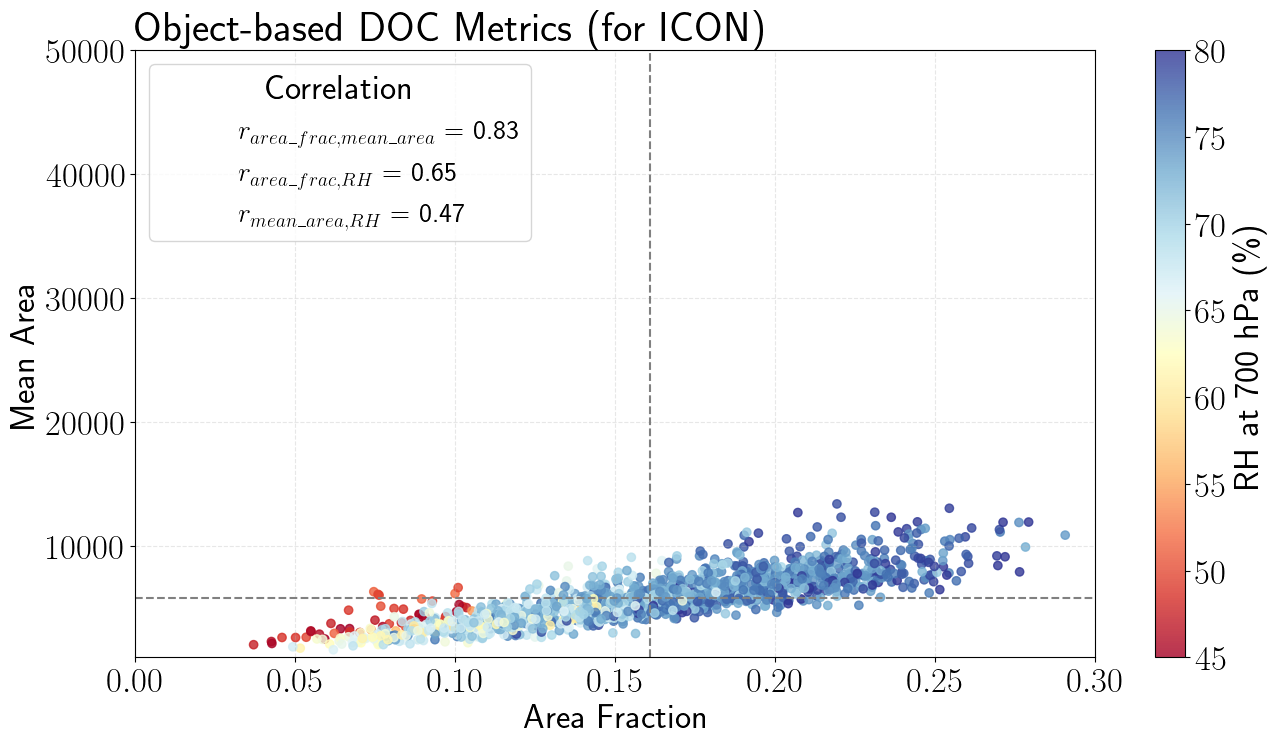

In [46]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import pandas as pd


data = pd.DataFrame({
    'icon_area_frac': icon_a,
    'icon_mean_area': icon_b,
    'icon_r_700_3h': icon_c
})


corr_ab, _ = pearsonr(data['icon_area_frac'], data['icon_mean_area'])
corr_ac, _ = pearsonr(data['icon_area_frac'], data['icon_r_700_3h'])
corr_bc, _ = pearsonr(data['icon_mean_area'], data['icon_r_700_3h'])


plt.rcParams.update({"text.usetex": True, "font.size": 25})
fig, ax = plt.subplots(figsize=(14, 8))

sc = ax.scatter(data['icon_area_frac'], data['icon_mean_area'], c=data['icon_r_700_3h'], cmap="RdYlBu", alpha=0.8, vmin = 45, vmax = 80)


ax.axhline(y=data['icon_mean_area'].mean(), ls="--", c="grey")
ax.axvline(x=data['icon_area_frac'].mean(), ls="--", c="grey")


ax.set_xlabel("Area Fraction")
ax.set_ylim(1000,50000)
ax.set_xlim(0,0.30)
ax.set_ylabel("Mean Area")
ax.set_title("Object-based DOC Metrics (for ICON)", loc="left")


cb = plt.colorbar(sc, ax=ax)
cb.set_label("RH at 700 hPa (\%)")


legend_elements = [
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,mean\_area}}$ = {corr_ab:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{area\_frac,RH}}$ = {corr_ac:.2f}"),
    Line2D([0], [0], linestyle='', marker='', label=fr"$r_{{mean\_area,RH}}$ = {corr_bc:.2f}")
]



ax.legend(handles=legend_elements, loc='upper left', frameon=True, title='Correlation', fontsize = 20)

# Grid and layout
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## Boxplot

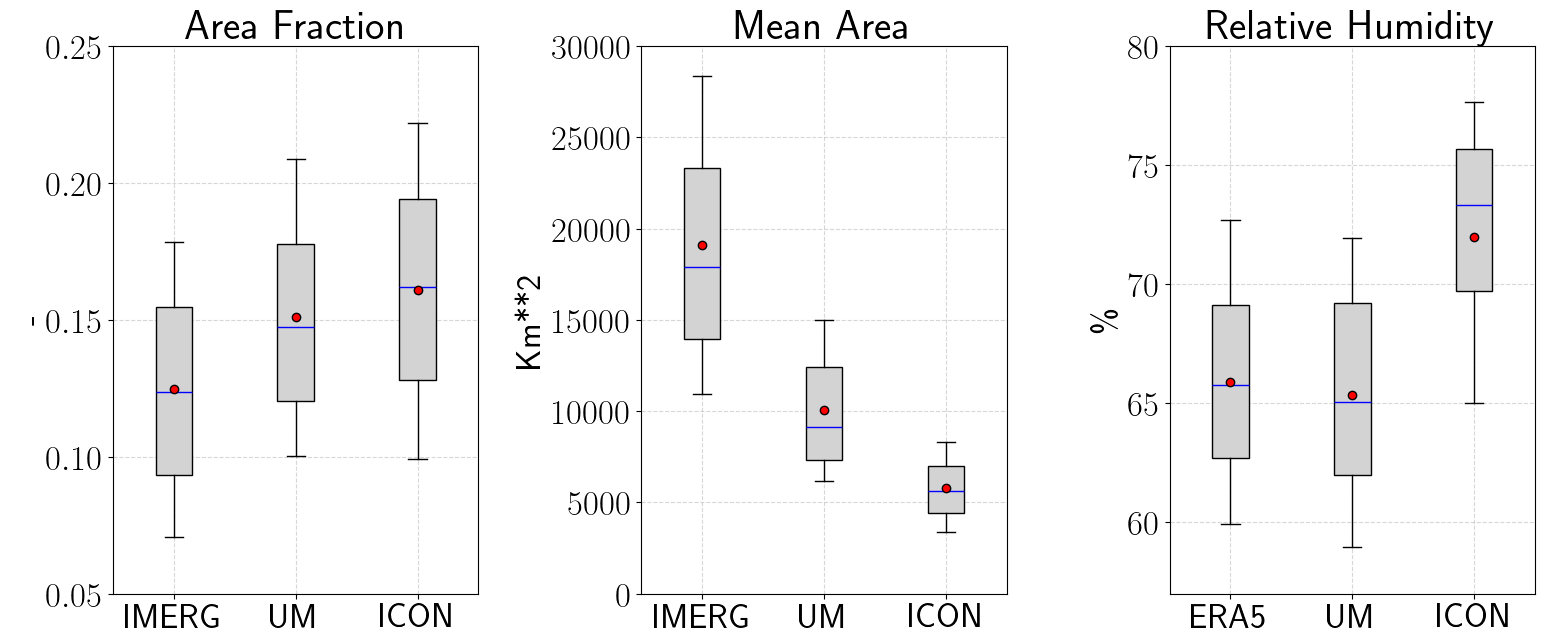

In [56]:
import numpy as np
import matplotlib.pyplot as plt

data_groups = [
    [ob_a, um_a, icon_a],
    [ob_b, um_b, icon_b],
    [ob_c, um_c, icon_c]
]

titles = ['Area Fraction', 'Mean Area', 'Relative Humidity']
y_labels = ['-', 'Km**2', '\%']
labels = ['IMERG', 'UM', 'ICON']
y_limits = [
    (0.05, 0.25),   
    (0, 30000), 
    (57, 80)    
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

for i, ax in enumerate(axes):
    bp = ax.boxplot(data_groups[i],
                    patch_artist=True,
                    showmeans=True, showfliers=False,
                    whis=[10, 90],  # <-- Set whiskers to min and max
                    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
                    medianprops={"color": "blue"},
                    boxprops={"facecolor": "lightgray"})

    ax.set_title(f'{titles[i]}')
    #ax.set_xticklabels(labels)
    if i == 2:
       ax.set_xticklabels(['ERA5', 'UM', 'ICON'])  # <-- custom labels for subplot 3
    else:
       ax.set_xticklabels(labels)

    ax.set_ylabel(f'{y_labels[i]}')
    ax.set_ylim(y_limits[i])
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## I_org and Relative Humidity

In [49]:
imerg_path_metrics = f"/g/data/nf33/cb4968/metrics/observations/IMERG/doc_metrics/" 
imerg_file_iorg = "i_org/IMERG/i_org_IMERG_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"

um_path_metrics = f"/g/data/nf33/cb4968/metrics/models/UM/doc_metrics/" 
um_file_iorg = "i_org/n2560_RAL3p3/i_org_n2560_RAL3p3_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"

icon_path_metrics = f"/g/data/nf33/cb4968/metrics/models/ICON/doc_metrics/" 
icon_file_iorg = "i_org/icon_d3hp003/i_org_icon_d3hp003_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc"

In [50]:

um_iorg = xr.open_dataset(f"{um_path_metrics}/{um_file_iorg}")
icon_iorg = xr.open_dataset(f"{icon_path_metrics}/{icon_file_iorg}")
imerg_iorg = xr.open_dataset(f"{imerg_path_metrics}/{imerg_file_iorg}")


# Select percentile
per = 95
um_iorg = um_iorg[f"i_org_thres_pr_percentiles_{per}"]
icon_iorg = icon_iorg[f"i_org_thres_pr_percentiles_{per}"]
imerg_iorg = imerg_iorg[f"i_org_thres_pr_percentiles_{per}"]


In [51]:
imerg_iorg

<xarray.DataArray 'i_org_thres_pr_percentiles_95' (time: 2918)> Size: 23kB
[2918 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 23kB 2020-03-01 ... 2021-02-28T21:00:00

In [52]:
# ICON relative humidity is 6 hourly! so, subset icon iorg to the times in icon reh h

icon_iorg = icon_iorg.sel(time=icon_c.time)

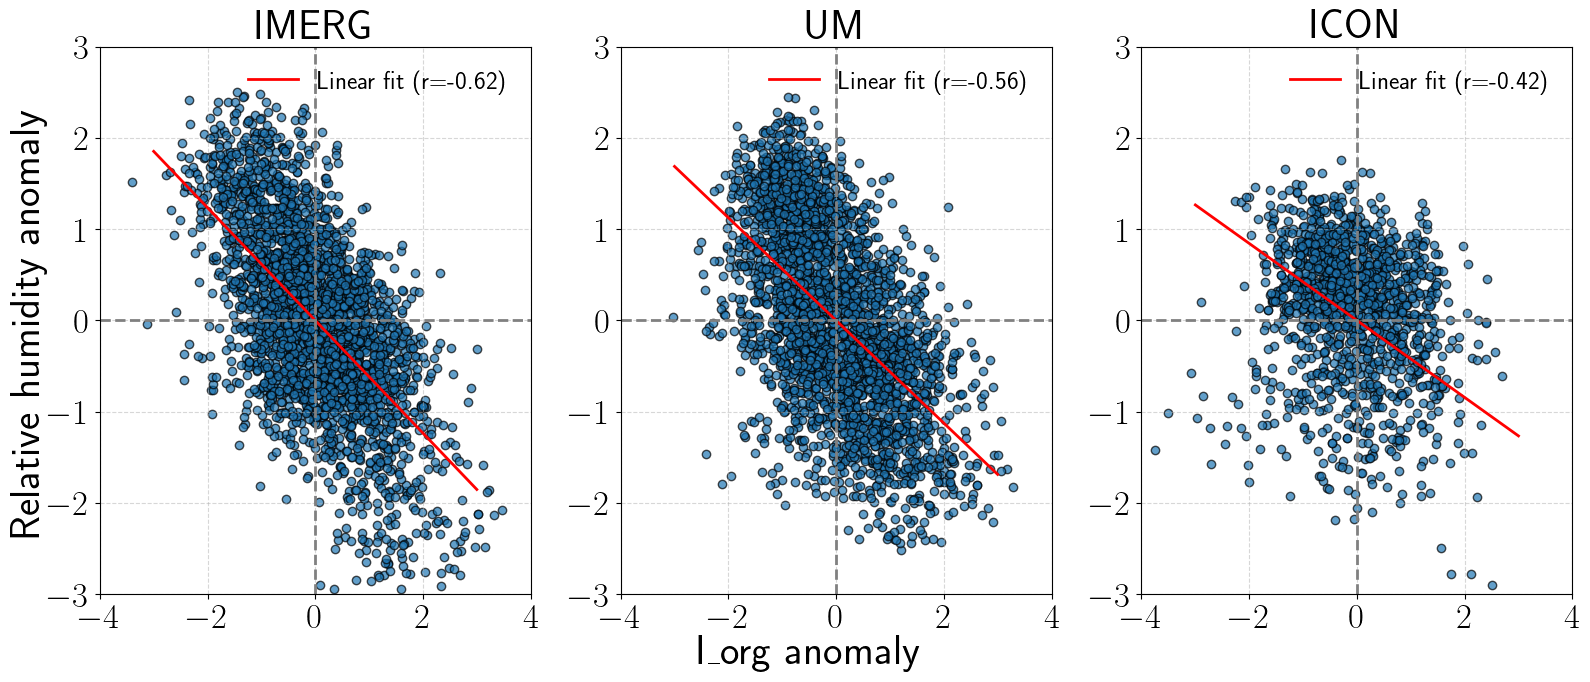

In [62]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Standardize each variable (x and y) to compute anomalies
x_data = [
    (imerg_iorg - imerg_iorg.mean()) / imerg_iorg.std(),
    (um_iorg - um_iorg.mean()) / um_iorg.std(),
    (icon_iorg - icon_iorg.mean()) / icon_iorg.std()
]

y_data = [
    (ob_c - ob_c.mean()) / ob_c.std(),
    (um_c - um_c.mean()) / um_c.std(),
    (icon_c - icon_c.mean()) / icon_c.std()
]

titles = ['IMERG', 'UM', 'ICON']

fig, axes = plt.subplots(1, 3, figsize=(16, 7))

for i, ax in enumerate(axes):
    
    x = x_data[i].values.flatten()
    y = y_data[i].values.flatten()
    
    
    ax.scatter(x, y, alpha=0.7, edgecolor='k')
    
    # Fit regression line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_fit = np.linspace(-3, 3, 100)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Linear fit (r={r_value:.2f})')

    
    ax.set_title(titles[i])
    ax.set_xlim(-4, 4)
    ax.set_ylim(-3, 3)
    ax.axhline(0, color='gray', linestyle='--', linewidth=2)
    ax.axvline(0, color='gray', linestyle='--', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize = 18, frameon= False)

plt.tight_layout()
fig.supxlabel('I_org anomaly', y=0.0001)
fig.supylabel('Relative humidity anomaly', x=0.0001)
plt.show()


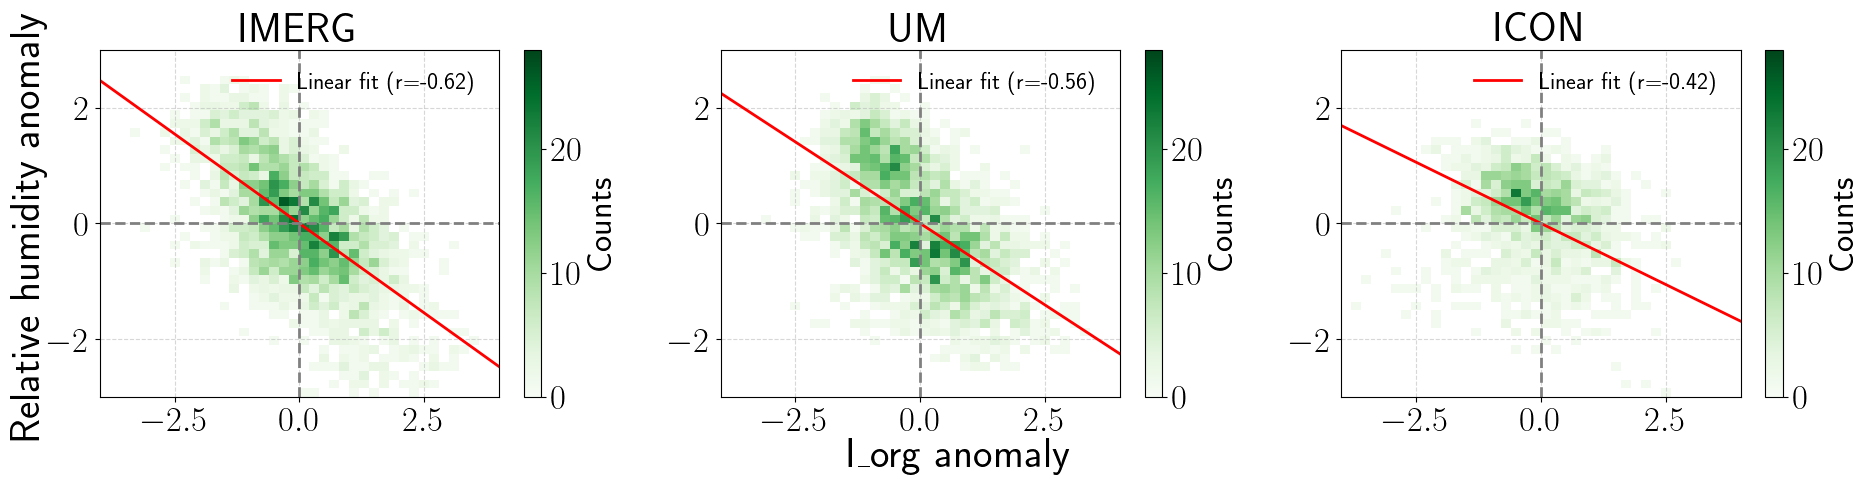

In [81]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np


x_data = [
    (imerg_iorg - imerg_iorg.mean()) / imerg_iorg.std(),
    (um_iorg - um_iorg.mean()) / um_iorg.std(),
    (icon_iorg - icon_iorg.mean()) / icon_iorg.std()
]

y_data = [
    (ob_c - ob_c.mean()) / ob_c.std(),
    (um_c - um_c.mean()) / um_c.std(),
    (icon_c - icon_c.mean()) / icon_c.std()
]

titles = ['IMERG', 'UM', 'ICON']
vmin_list = [0, 0, 0]       # Set per-subplot vmin
vmax_list = [28, 28, 28]    # Set per-subplot vmax

fig, axes = plt.subplots(1, 3, figsize=(19, 5))

for i, ax in enumerate(axes):
    x = x_data[i].values.flatten()
    y = y_data[i].values.flatten()

    # Define norm 
    norm = Normalize(vmin=vmin_list[i], vmax=vmax_list[i])

    # 2D histogram 
    h = ax.hist2d(x, y, bins=40, range=[[-4, 4], [-3, 3]],
                  cmap='Greens', cmin=1, norm=norm)

 
    fig.colorbar(h[3], ax=ax, orientation='vertical', label='Counts')

    # Regression line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_fit = np.linspace(-4, 4, 100)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Linear fit (r={r_value:.2f})')


    ax.set_title(titles[i])
    ax.set_xlim(-4, 4)
    ax.set_ylim(-3, 3)
    ax.axhline(0, color='gray', linestyle='--', linewidth=2)
    ax.axvline(0, color='gray', linestyle='--', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=17, frameon=False)

plt.tight_layout()
fig.supxlabel('I_org anomaly', y=0.0001)
fig.supylabel('Relative humidity anomaly', x=0.0001)
plt.show()
